<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1>Using Dropout for Classification </h1>


<h3>Objective for this Notebook<h3>    
<h5> 1. Create the Model and Cost Function the PyTorch way.</h5>
<h5> 2. Batch Gradient Descent </h5>    


<h2>Table of Contents</h2>
<p>In this lab, you will see how adding dropout to your model will decrease overfitting.</p>

<ul>
<li><a href="https://#Makeup_Data">Make Some Data</a></li>
<li><a href="https://#Model_Cost">Create the Model and Cost Function the PyTorch way</a></li>
<li><a href="https://#BGD">Batch Gradient Descent</a></li>
</ul>
<p>Estimated Time Needed: <strong>20 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries


In [22]:
# Import the libraries we need for this lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

Use this function only for plotting:


In [23]:
# The function for plotting the diagram

def plot_decision_regions_3class(data_set, model=None):
    cmap_light = ListedColormap([ '#0000FF','#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]
    
    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    if model != None:
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light) 

    plt.title("decision region vs True decision boundary")

Use this function to calculate accuracy:


In [24]:
# The function for calculating accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data</h2>


Create a nonlinearly separable dataset:


In [25]:
# Create data class for creating dataset object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        
    # Getter        
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

Create a dataset object:


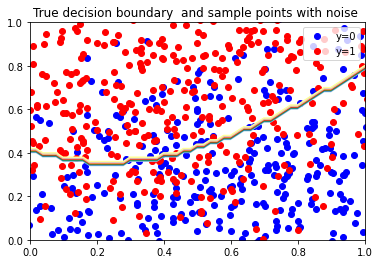

In [26]:
# Create a dataset object

data_set = Data(noise_std=0.2)
data_set.plot()

Validation data:


In [27]:
# Get some validation data

torch.manual_seed(0) 
validation_set = Data(train=False)

<!--Empty Space for separating topics-->


<h2 id="Model_Cost">Create the Model, Optimizer, and Total Loss Function (Cost)</h2>


Create a custom module with three layers. <code>in_size</code> is the size of the input features, <code>n_hidden</code> is the size of the layers, and <code>out_size</code> is the size. <code>p</code> is the dropout probability. The default is 0, that is, no dropout.


In [28]:
# Create Net Class

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
    
    # Prediction function
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

Create two model objects: <code>model</code> had no dropout and <code>model_drop</code> has a dropout probability of 0.5:


In [29]:
# Create two model objects: model without dropout and model with dropout

model = Net(2, 300, 2)
model_drop = Net(2, 300, 2, p=0.5)

<!--Empty Space for separating topics-->


<h2 id="BGD">Train the Model via Mini-Batch Gradient Descent</h2>


Set the model using dropout to training mode; this is the default mode, but it's  good practice to write this in your code :


In [8]:
# Set the model to training mode

model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)

Train the model by using the Adam optimizer. See the unit on other optimizers. Use the Cross Entropy Loss:


In [9]:
# Set optimizer functions and criterion functions

optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

Initialize a dictionary that stores the training and validation loss for each model:


In [10]:
# Initialize the LOSS dictionary to store the loss

LOSS = {}
LOSS['training data no dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data dropout'] = []

Run 500 iterations of batch gradient gradient descent:


In [15]:
# Train the model

epochs = 500

def train_model(epochs):
    
    for epoch in range(epochs):
        #all the samples are used for training 
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for both the training and validation data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()
        
train_model(epochs)

Set the model with dropout to evaluation mode:


In [16]:
# Set the model to evaluation model

model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)

Test the model without dropout on the validation data:


In [17]:
# Print out the accuracy of the model without dropout

print("The accuracy of the model without dropout: ", accuracy(model, validation_set))

The accuracy of the model without dropout:  0.753


Test the model with dropout on the validation data:


In [18]:
# Print out the accuracy of the model with dropout

print("The accuracy of the model with dropout: ", accuracy(model_drop, validation_set))

The accuracy of the model with dropout:  0.855


You see that the model with dropout performs better on the validation data.


<h3>True Function</h3>


Plot the decision boundary and the prediction of the networks in different colors.


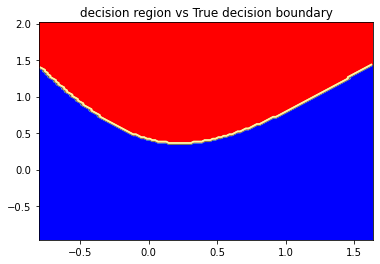

In [19]:
# Plot the decision boundary and the prediction

plot_decision_regions_3class(data_set)

Model without Dropout:


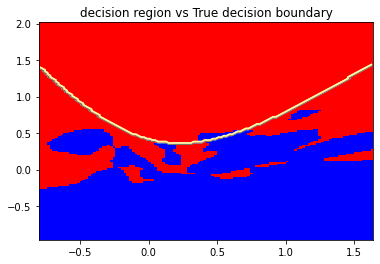

In [20]:
# The model without dropout

plot_decision_regions_3class(data_set, model)

Model with Dropout:


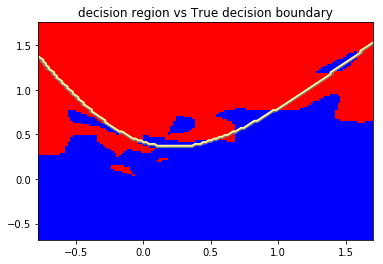

In [29]:
# The model with dropout

plot_decision_regions_3class(data_set, model_drop)

You can see that the model using dropout does better at tracking the function that generated the data.


Plot out the loss for the training and validation data on both models, we use the log to make the difference more apparent


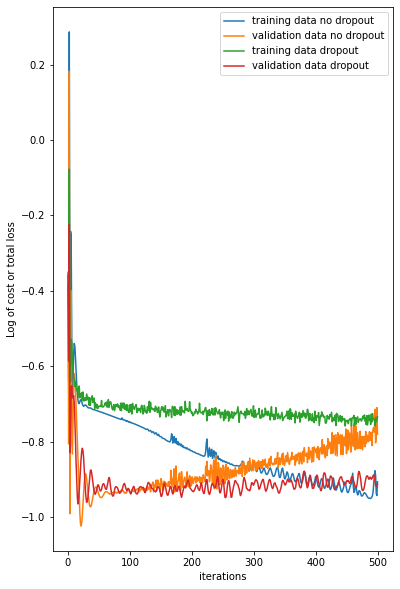

In [21]:
# Plot the LOSS

plt.figure(figsize=(6.1, 10))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()

You see that the model without dropout performs better on the training data, but it performs worse on the validation data. This suggests overfitting.  However, the model using dropout performed better on the validation data, but worse on the training data.


<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"/></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork20647811-2022-01-01">Mavis Zhou</a>


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-23        | 2.0     | Srishti    | Migrated Lab to Markdown and added to course repo in GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
